# Feature Matching

The task of matching features from multiple images and finding an image within another. Before matching features, we first need to detect and describe keypoints in each available image.

For detection and description, we can use algorithm's like FAST, BRIEF, ORB, SIFT, SURF and Corner Detectors. These methods inherit from `features2D` class in OpenCV, hence, we can use the `detectandCompute` method to get keypoints in each image and their descriptors.

For this example, we will use the SIFT descriptor with flann-based KNN matcher.

### Loading Images

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Haystack')

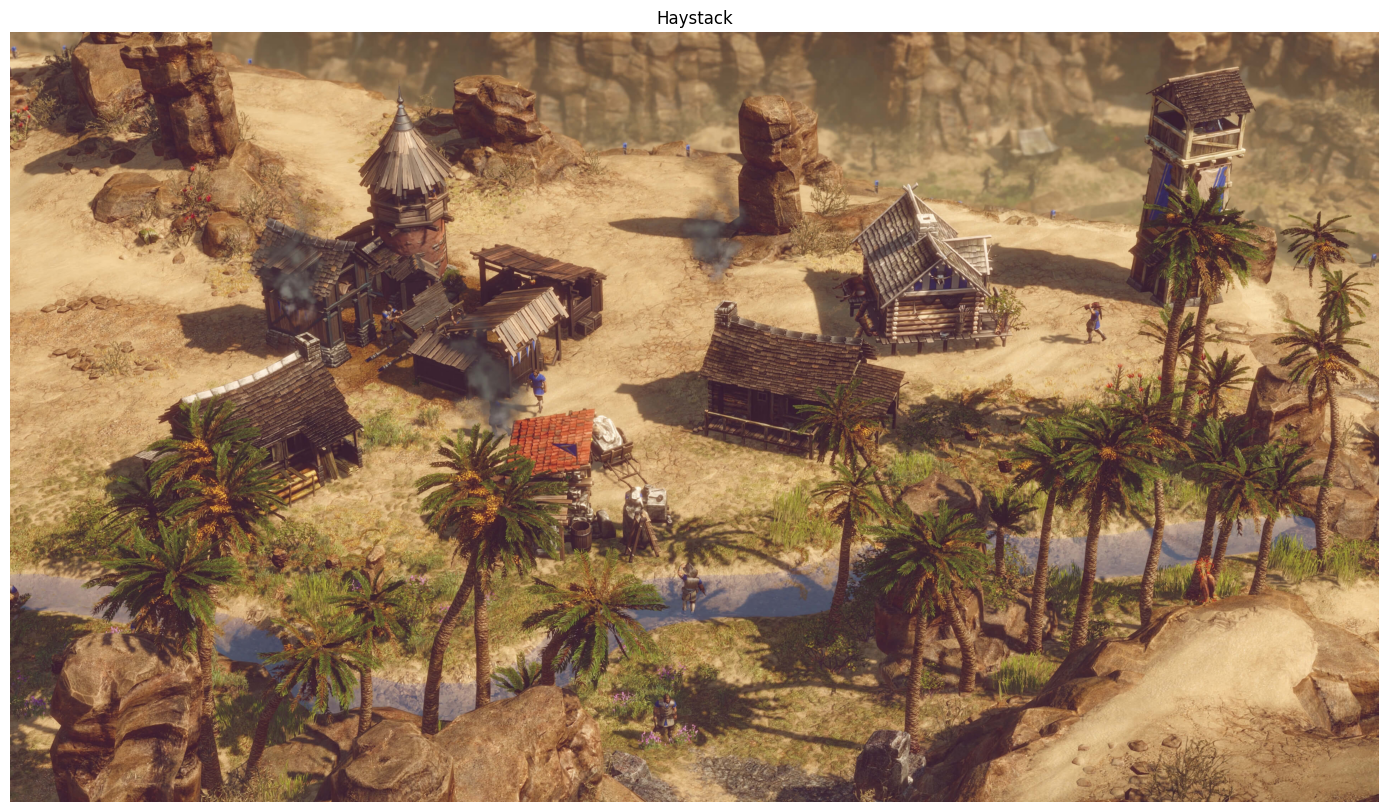

In [83]:
haystack = cv2.imread('images/haystack.jpg')

plt.figure(figsize=[20, 10])
plt.imshow(haystack[:, :, ::-1]); plt.axis('off'); plt.title('Haystack')

Text(0.5, 1.0, 'Needle')

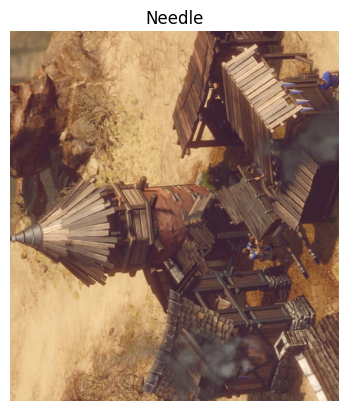

In [6]:
needle = cv2.imread('images/needle.jpg')
plt.imshow(needle[:, :, ::-1]); plt.axis('off'); plt.title('Needle')

Now that we have our images, we can go on and find keypoints and descriptors from the images.

### Finding Keypoints and Descriptors

In [12]:
#create a SIFT object
sift_detector = cv2.SIFT.create(nfeatures=700)

#detect keypoints and descriptors
key1, des1 = sift_detector.detectAndCompute(haystack, None)
key2, des2 = sift_detector.detectAndCompute(needle, None)

### Matching

In order to find the needle in the haystack, we need to match up the keypoints in the needle and haystack. OpenCV provides 2 matchers... the Brute Force Matcher and the Flann Matcher. For this case, we will use the Flann matcher.

For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters - these dictionaries are indexParams and SearchParams (it specifies the number of times the trees in the index should be recursively traversed).

In [26]:
#recommended values for SIFT, SURF etc.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

# creating flann object
flann = cv2.FlannBasedMatcher(index_params, search_params)

#getting knn matches
matches_knn = flann.knnMatch(des1, des2, k=2)

### Lowe's Ratio Test

The parameter K in knnMatch defines the number of comparisons we will do. Since we have set K as 2, we are returning, for each descriptor of needle, two descriptors of haystack. We can check this quickly: if we take any tuple of matches, we can see that they match to one query descriptor and yet are different train descriptors.

In [32]:
m, n = matches_knn[0]
print(m.distance, n.distance)
#we see that they have the same query index
print(m.queryIdx, n.queryIdx)
print(m.trainIdx, n.trainIdx)

366.702880859375 367.479248046875
0 0
474 692


With this, we can then reason out that if the keypoints of each image are unique, then they should not have more than one corresponding keypoint in the subsequent image. Hence, what we do is that we check the distance between m and n. If the distances are sufficiently divergent we take the smaller distance. If not, then it means that our keypoint in A has multiple similar keypoints in B, it is not unique, hence, we discard m.

More info [here](https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work).

In [45]:
#applying the ratio test to take good matches
good = []
for m, n in matches_knn:
    if m.distance < 0.7*n.distance:
        good.append(m)

### Finding Homography between the Images

In [60]:
src_pts = np.float32( [key1[m.queryIdx].pt for m in good] ).reshape(-1, 1, 2)
dst_pts = np.float32( [key2[m.trainIdx].pt for m in good] ).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

Now that we have a homography, we will take the inliers used to compute the homography defined by mask and store them. We will use this to draw the inliers later. 

The difference between `findHomography` and `getPerspectiveTransform` is that `getPerspectiveTransform` requires exactly 4 pairs of corresponding points. These points must be in a specific order and must be co-planar whereas `findHomography` can work with 4 or more pairs of points. It uses algorithms like RANSAC to find the best perspective transformation, even if some points are outliers.

As to use cases `getPerspectiveTransform` is ideal for situations where you have a known set of good points and need a straightforward perspective transformation whereas findHomography is more flexible and robust, and is suitable for scenarios where you have a larger set of points and need to account for potential noise or outliers.

In [64]:
matchesMask = mask.ravel().tolist()

Next, we use the homography to create a perspective transform of corner points in the needle image to the haystack image. We then draw lines corresponding to these points in the haystack image.

In [77]:
hn, wn = needle.shape[:2]
pts_needle = np.float32([[0, 0], [0, hn-1], [wn-1, hn-1], [wn-1, 0]]).reshape(-1, 1, 2)

pts_haystack = cv2.perspectiveTransform(pts_needle, np.linalg.inv(H))

`pts_haystack` is now the correct transformation of the corner points of needle in haystack. We can draw this outline and also draw the inlier points described by the mask.

### Drawing

(-0.5, 3839.5, 2159.5, -0.5)

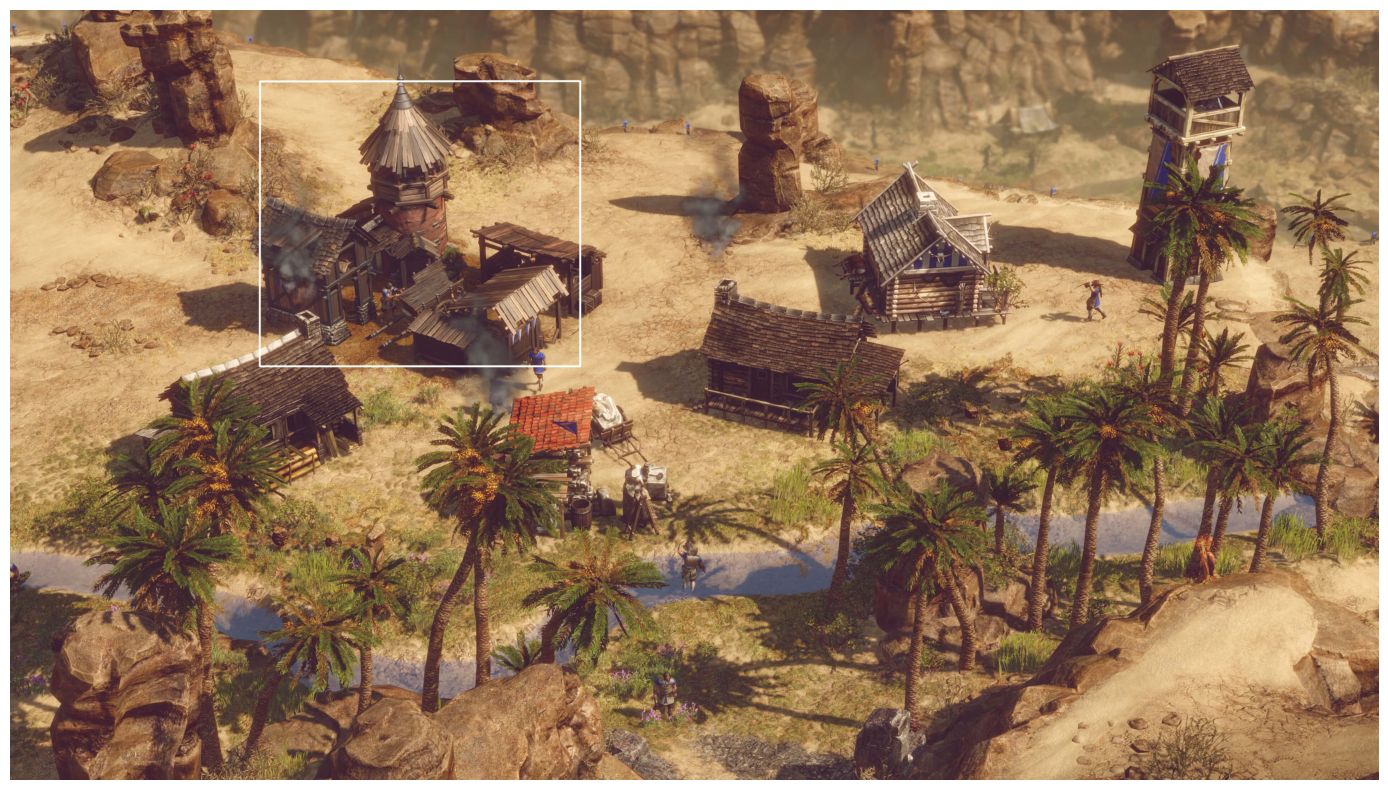

In [85]:
new_haystack = haystack.copy()
new_haystack = cv2.polylines(new_haystack, [np.int32(pts_haystack)], True, (255, 255, 255), 3, cv2.LINE_AA)

plt.figure(figsize=[20, 10])
plt.imshow(new_haystack[:, :, ::-1]); plt.axis('off')

We now draw the matches that were used for both images in computing the homography.

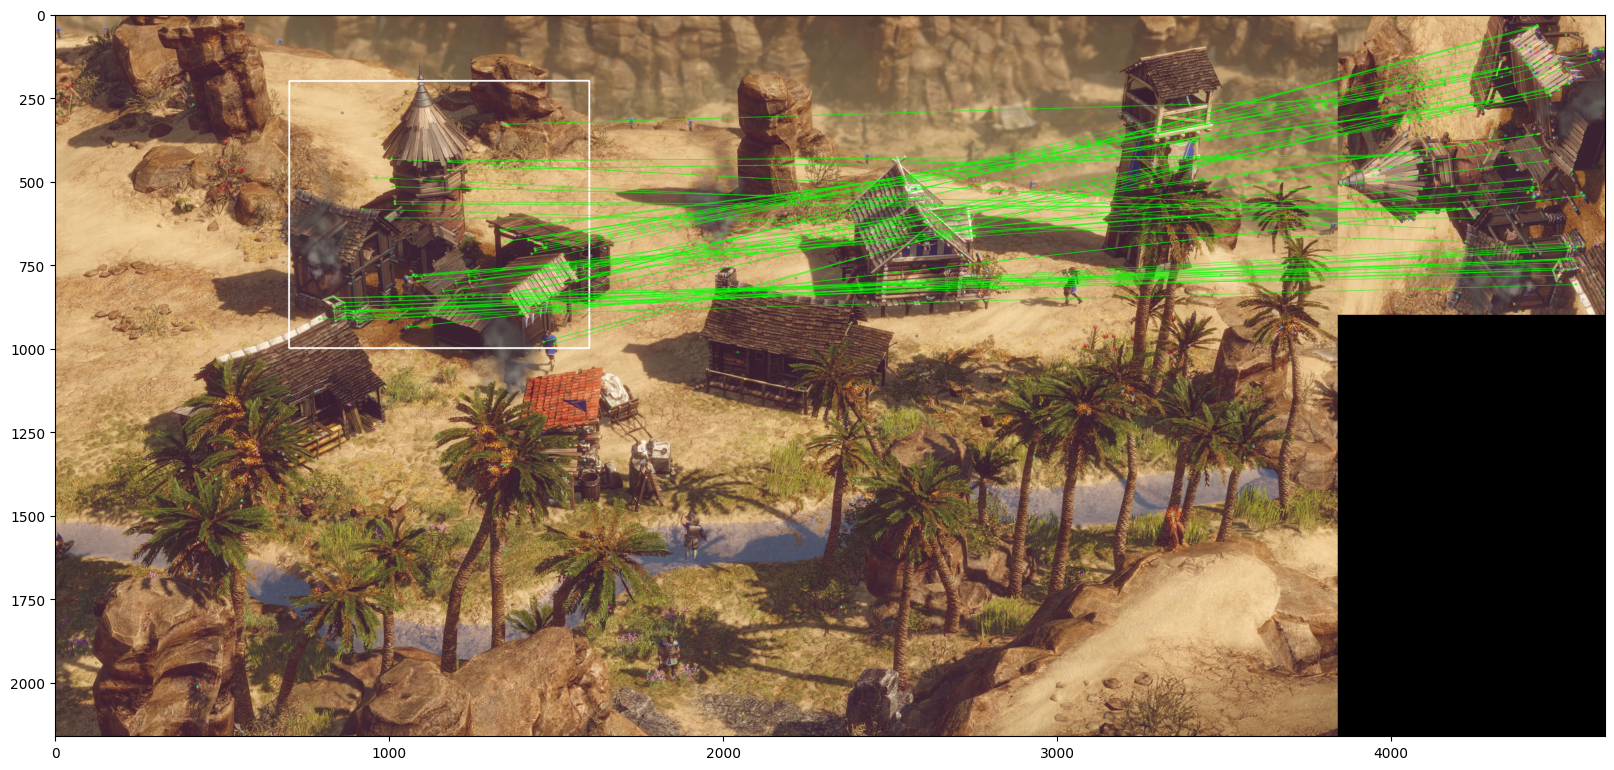

In [86]:
drawn_final = cv2.drawMatches(new_haystack, key1, needle, key2, good, None, matchColor=(0, 255, 0),matchesMask=matchesMask)

plt.figure(figsize=[20, 10])
plt.imshow(drawn_final[:, :, ::-1])

And there we have it. Using FLANN-based matcher with SIFT detector and Lowe's ratio test.